# The Age-Velocity Dispersion Relations in GALAH DR3

The purpose of this tutorial is to: 
1. Introduce the concepts of Age-Velocity Dispersion relations
2. Introduce Cross matching via topcat
3. Introduce/practice velocity calculations via astropy 

Goal: You will derive the Gaia DR2-GALAH Age-Velocity Dispersion relations. Two additional challenges include: (1) derive the same Age-Velocity Dispersion relations but for  Gaia DR3-GALAH (hint!: this will require a cross match) and (2) consider uncertainties in age and velocity to build a linear model which converts velocity dispersion into age.

We will start by importing libraries

In [1]:
import numpy as np
import pylab as p
import astropy
from astropy.table import Table
import scipy.stats
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.coordinates import Galactic
from astropy.coordinates import ICRS
import astropy.coordinates as apycord
import random

#lets now make the plots interactive and reset some defaults.
%matplotlib inline
p.rc('axes',prop_cycle=(p.cycler('color', ['k','b','g','r','c','m','y'])))
p.rcParams['lines.linewidth']= 1.5
p.rcParams['axes.linewidth']=2.0

p.rcParams['text.usetex']= True
#p.rcParams['font.family']='times'
p.rcParams['mathtext.fontset']= 'custom'
p.rcParams['mathtext.default']= 'rm'

p.rcParams['font.size']= 15.0
p.rcParams['axes.formatter.use_mathtext']=False
p.rcParams['axes.labelsize']=16.0
p.rcParams['axes.unicode_minus']=False
p.rcParams['xtick.major.size']=6
p.rcParams['xtick.minor.size']=3
p.rcParams['xtick.major.width']=1.5#2.0
p.rcParams['xtick.minor.width']=1.0

p.rcParams['axes.linewidth']=2.5
#p.rcParams['axes.labelsize']='medium'
p.rcParams['axes.titlesize']=20#'large'
#p.rcParams['xtick.labelsize'] = 'medium' # fontsize of the tick labels
#p.rcParams['ytick.labelsize']='medium'
p.rcParams['xtick.labelsize'] = 20#'x-large' # fontsize of the tick labels
p.rcParams['ytick.labelsize']=20 #'x-large'


#p.rcParams['ytick.major.size']=6
#p.rcParams['ytick.minor.size']=3
p.rcParams['ytick.major.width']=2.0 #4
p.rcParams['ytick.minor.width']=1.0 #2.0
p.rcParams['ps.fonttype'] = 42
p.rcParams['pdf.fonttype'] = 42
p.rcParams['savefig.dpi']=300
p.rcParams['savefig.format']='pdf'

We will need to download the GALAH DR3 dataset that contains age information. This dataset also contains DR2 estimates of velocity but *NOT* DR3:

DATA LOCATION : https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR3/
Main GALAH Table :
-GALAH_DR3_main_allstar_v2.fits -- Main GALAH DR3
-GALAH_DR3_VAC_ages_v2.fits -- GALAH DR3 ages
-GALAH_DR3_VAC_GaiaEDR3_v2.fits	-- GaiaEDR3 x GALAH


Download this dataset
and load it in with astropy!



In [2]:
datapath = '/Users/kh36543/Desktop/data/YAR/'
GALAH = Table.read(datapath+'GALAH_master_age.fits')

In [3]:
#explore the columns:

#print GALAH.colnames

The goal here is to determine how velocity (and velocity dispersion) is correlated with age. 

As such we will need to find the (precomputed DR2) velocity columns; and age columns (based on the cell above). 

Not all velociities and ages are measured with the same precision so we will also want to apply some very simple quality control cuts. So lets do that in the next cell

In [4]:
#lets create a quality 
v_err_lim = 5 # define the limiting velocity uncertinaty in all axes
age_err_lim = 0.3 #age uncertainty limit in percent
dist_err_lim = 0.15 #distance error in percent



ok = np.where((GALAH['vR_Rzphi_50']-GALAH['vR_Rzphi_5'] < v_err_lim) & (GALAH['vT_Rzphi_50']-GALAH['vT_Rzphi_5'] < v_err_lim)&\
              (GALAH['vz_Rzphi_50']-GALAH['vz_Rzphi_5'] < v_err_lim) &(GALAH['e_age_bstep']/GALAH['age_bstep'] < age_err_lim)&\
              (GALAH['parallax_error']/GALAH['parallax'] < dist_err_lim) &(GALAH['age_bstep']>1)&(GALAH['age_bstep']<10))[0] 

print 'There are %i stars that pass the quality controls'%len(ok)
D = GALAH[ok]

/Users/kh36543/anaconda2/lib/python2.7/site-packages/astropy/table/column.py:954: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/Users/kh36543/anaconda2/lib/python2.7/site-packages/astropy/table/column.py:954: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


There are 204094 stars that pass the quality controls


With the 'quality' sample in hand, lets now try to figure out how velocity and velocity dispersion depends on age in this sample. We will start by simply plotting velocity in all directions as a function of age

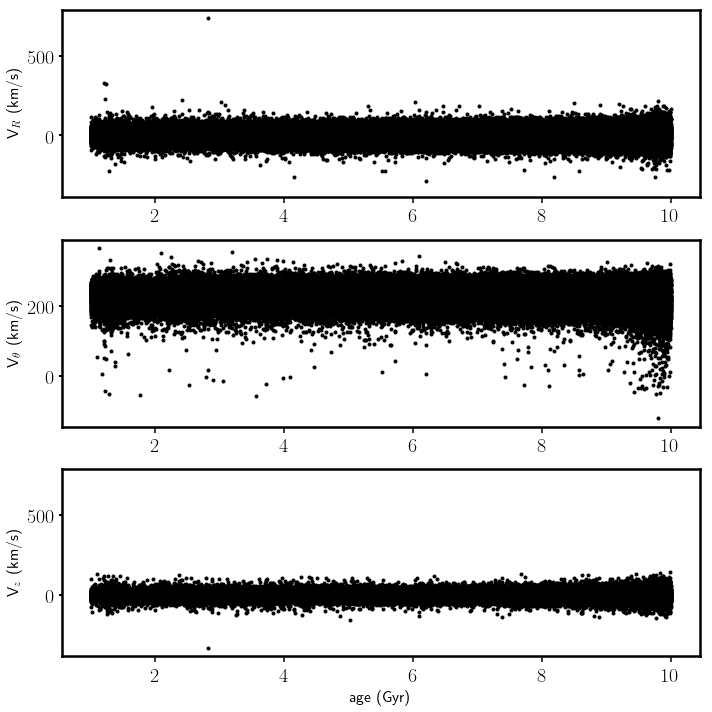

In [5]:
#Now we want to plot how the velocities depends on age
p.figure(figsize=(10,10))
ax1 = p.subplot(3,1,1)
p.plot(D['age_bstep'], D['vR_Rzphi_50'],'.')
p.ylabel('V$_R$ (km/s)')

ax2 = p.subplot(3,1,2, sharex=ax1)
p.plot(D['age_bstep'], D['vT_Rzphi_50'],'.')
p.ylabel(r'V$_{\theta}$ (km/s)')

ax3 = p.subplot(3,1,3, sharey=ax1)
p.plot(D['age_bstep'], D['vz_Rzphi_50'],'.')
p.ylabel('V$_z$ (km/s)')
p.xlabel('age (Gyr)')
p.tight_layout()

From the above plots we can see that:
1. Mostly velocities are indepdent of age (no signficant relationships), except maybe in V_theta (V_t)
2. The velocity dispersion in all velcoity directons likley grows with increasing age

So lets bin by age and see if we can determine the relationship between age and velocity.

In [6]:
# for each star we will place them into bins by age using scipy.stats.binned_statistic 

age_bins = [3,4,5,6,7,8,9,10] #define the limits of each bin

## With the ages now binned up lets plot compute the bin's mean age and dispersion in age for each velocity direction
mean_VR, bin_edge,inds = scipy.stats.binned_statistic(D['age_bstep'],D['vR_Rzphi_50'] , statistic='mean', bins=age_bins)
std_VR, bin_edge,inds = scipy.stats.binned_statistic(D['age_bstep'],D['vR_Rzphi_50'] , statistic='std', bins=age_bins)

mean_Vz, bin_edge,inds = scipy.stats.binned_statistic(D['age_bstep'],D['vz_Rzphi_50'] , statistic='mean', bins=age_bins)
std_Vz, bin_edge,inds = scipy.stats.binned_statistic(D['age_bstep'],D['vz_Rzphi_50'] , statistic='std', bins=age_bins)

mean_Vt, bin_edge,inds = scipy.stats.binned_statistic(D['age_bstep'],D['vT_Rzphi_50'] , statistic='mean', bins=age_bins)
std_Vt, bin_edge,inds = scipy.stats.binned_statistic(D['age_bstep'],D['vT_Rzphi_50'] , statistic='std', bins=age_bins)

bincen = [(bin_edge[i+1]+ bin_edge[i])/2. for i in range(len(age_bins)-1)] #this set the bin centers

/Users/kh36543/anaconda2/lib/python2.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Now that we have binned the data and determined the mean and dispersion in each velocity direction, as a sanity check (which are incredibly important to do), lets overplot the data and the binned results to ensure it looks ok.

# The Age-Velocity Dispersion Relations in GALAH-Gaia DR2


Now we are ready to plot the age velocity disperison relations for each component for GALAH-Gaia DR2. 

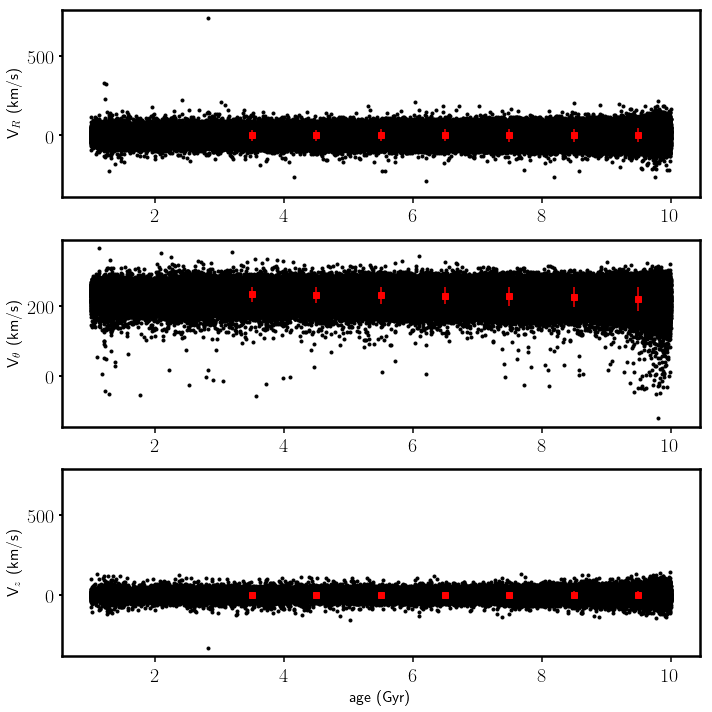

In [7]:
p.figure(figsize=(10,10))
ax1 = p.subplot(3,1,1)
p.plot(D['age_bstep'], D['vR_Rzphi_50'],'.')
p.errorbar(bincen,mean_VR,yerr=std_VR, fmt='s',color='r',zorder=3 )
p.ylabel('V$_R$ (km/s)')

ax2 = p.subplot(3,1,2, sharex=ax1)
p.plot(D['age_bstep'], D['vT_Rzphi_50'],'.')
p.errorbar(bincen,mean_Vt,yerr=std_Vt, fmt='s',color='r',zorder=3 )
p.ylabel(r'V$_{\theta}$ (km/s)')

ax3 = p.subplot(3,1,3, sharey=ax1)
p.plot(D['age_bstep'], D['vz_Rzphi_50'],'.')
p.errorbar(bincen,mean_Vz,yerr=std_Vz, fmt='s',color='r',zorder=3 )
p.ylabel('V$_z$ (km/s)')
p.xlabel('age (Gyr)')
p.tight_layout()

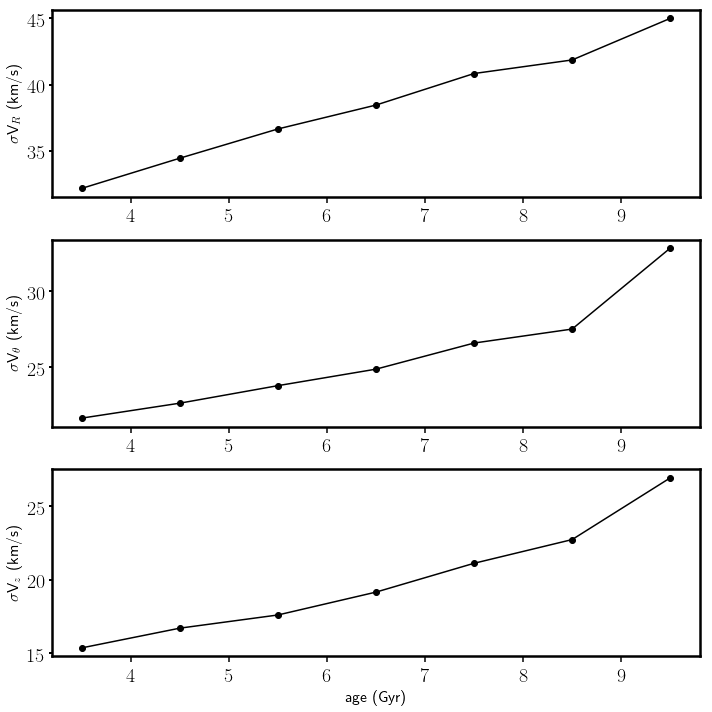

In [8]:
p.figure(figsize=(10,10))
ax1 = p.subplot(3,1,1)
p.plot(bincen,std_VR,'-o')
p.ylabel(r'$\sigma$V$_R$ (km/s)')

ax2 = p.subplot(3,1,2,sharex=ax1)
p.plot(bincen,std_Vt,'-o')
p.ylabel(r'$\sigma$V$_{\theta}$ (km/s)')

ax1 = p.subplot(3,1,3,sharex=ax1)
p.plot(bincen,std_Vz,'-o')
p.ylabel(r'$\sigma$V$_z$ (km/s)')
p.xlabel('age (Gyr)')
p.tight_layout()

*We now see that the age-velocity dispersion relations are roughly linear such that VELOCITY DISPERSION INCREASES with INCREASING age as expect*

# The Age-Velocity Dispersion Relations in GALAH-Gaia EDR3!

Let us now redo the above but with EDR3 data instead! This will require us to compute the velocities (and their uncertainties -- challenge) from the EDR3 data directly.

You will need to first cross-match (via ADQL/TOPCAT/TAP QUERY/ASTROQUERY you choose the orginal table with ED3.

In [9]:
# --- ok lets now compute some velocities with EDR3 data! We start by making a defintion.
def compute_vels(ra,dec,pmra,pmdec,rv,dist, V0 = [11.1,245.,7.25], R0=8.3):
    icrs = ICRS(ra=ra*u.deg, dec=dec*u.deg, distance=dist*u.kpc,pm_ra_cosdec=pmra*u.mas/u.yr, \
                            pm_dec=pmdec*u.mas/u.yr, radial_velocity=rv*u.km/u.s)

    #Define the GC frame:
    v_sun = apycord.CartesianDifferential(V0*u.km/u.s)
    gc_frame= apycord.Galactocentric(galcen_distance=R0*u.kpc,
                                   z_sun=25.*u.pc,
                                   galcen_v_sun=v_sun)
    #convert to GC frame
    cg= icrs.transform_to(gc_frame)
    #cg.representation= 'cartesian'
    cg.representation = 'cylindrical' #and now to clylindrical coords
    VR = cg.d_rho.to(u.km/u.s).value
    VT = (cg.d_phi*cg.rho).to(u.km/u.s, equivalencies=u.dimensionless_angles()).value
    VZ = cg.d_z.to(u.km/u.s).value
    
    return VR,-VT,VZ

With the definition, we can now convert the observables into velocities by calling the defintion from above. We can also do this iterativley where in each iteration we perturb the input observables by the uncertainties. This will enable us to estimate the velocity uncertainties via monte carlo realizations.

In [10]:
#----lets now deal with the velocity uncertinaties via monte carlo realizations

allVR = []
allVT = []
allVZ = []
niter = 2
for i in range(niter):
    pmra_perturb = np.random.normal(0,GALAH['pmra_error_edr3'])
    pmdec_perturb = np.random.normal(0,GALAH['pmdec_error_edr3'])
    rv_perturb = np.random.normal(0,GALAH['e_rv_galah'])
    parallax = np.random.normal(0,GALAH['parallax_error_edr3'])
    
    A = compute_vels(np.array(GALAH['ra_edr3']),np.array(GALAH['dec_edr3']),\
                     np.array(GALAH['pmra_edr3']),np.array(GALAH['pmdec_edr3']),\
                     np.array(GALAH['rv_galah']),1./(np.array(GALAH['parallax_edr3'])) )
    allVR.append(A[0]) ; allVT.append(A[1]); allVZ.append(A[2])
    
GALAH['galvr_dr3'] = np.median(allVR,axis=0)
GALAH['galvr_err_dr3'] = np.std(allVR,axis=0)
GALAH['galvt_dr3'] = np.median(allVT,axis=0)
GALAH['galvt_err_dr3'] = np.std(allVT,axis=0)
GALAH['galvz_dr3'] = np.median(allVZ,axis=0)
GALAH['galvz_err_dr3'] = np.std(allVZ,axis=0)

/Users/kh36543/anaconda2/lib/python2.7/site-packages/astropy/coordinates/angles.py:651: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/kh36543/anaconda2/lib/python2.7/site-packages/astropy/coordinates/angles.py:651: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/kh36543/anaconda2/lib/python2.7/site-packages/astropy/coordinates/angles.py:534: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/kh36543/anaconda2/lib/python2.7/site-packages/astropy/coordinates/angles.py:534: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/kh36543/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median for 

Now that we have the velocities and their uncertainties with EDR3 data, lets make the same quality control cuts as before.

In [11]:
ok = np.where((GALAH['galvr_err_dr3'] < v_err_lim) & (GALAH['galvt_err_dr3']< v_err_lim) &\
              (GALAH['galvz_err_dr3']<v_err_lim) &(GALAH['e_age_bstep']/GALAH['age_bstep'] < age_err_lim)&\
              (GALAH['parallax_error']/GALAH['parallax'] < dist_err_lim) &(GALAH['age_bstep']>1)&(GALAH['age_bstep']<10))[0] 

print 'There are %i stars that pass the quality controls'%len(ok)
D_DR3 = GALAH[ok]

There are 211067 stars that pass the quality controls


We can now plot the EDR3 version of the age velocity relations.

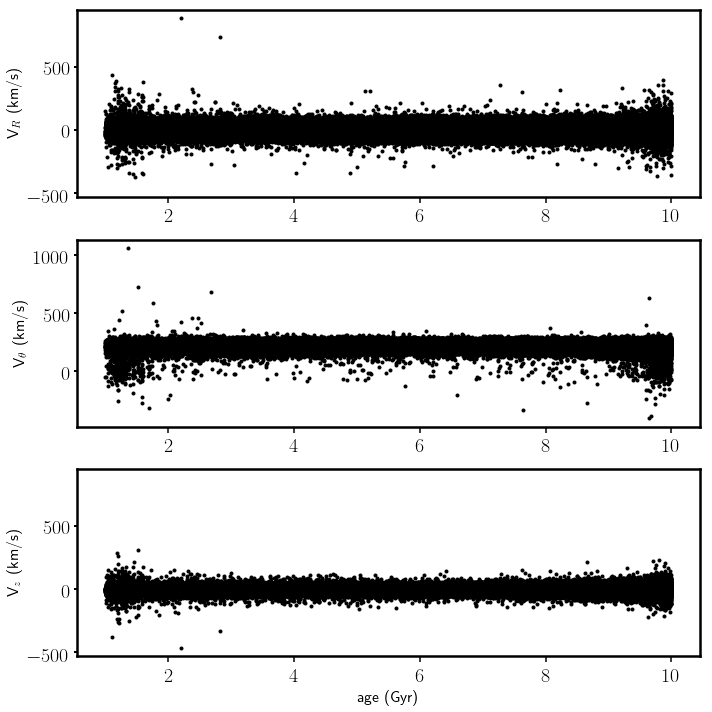

In [12]:
p.figure(figsize=(10,10))
ax1 = p.subplot(3,1,1)
p.plot(D_DR3['age_bstep'], D_DR3['galvr_dr3'],'.')
#p.errorbar(bincen,mean_VR,yerr=std_VR, fmt='s',color='r',zorder=3 )
p.ylabel('V$_R$ (km/s)')

ax2 = p.subplot(3,1,2, sharex=ax1)
p.plot(D_DR3['age_bstep'], D_DR3['galvt_dr3'],'.')
#p.errorbar(bincen,mean_Vt,yerr=std_Vt, fmt='s',color='r',zorder=3 )
p.ylabel(r'V$_{\theta}$ (km/s)')

ax3 = p.subplot(3,1,3, sharey=ax1)
p.plot(D_DR3['age_bstep'], D_DR3['galvz_dr3'],'.')
#p.errorbar(bincen,mean_Vz,yerr=std_Vz, fmt='s',color='r',zorder=3 )
p.ylabel('V$_z$ (km/s)')
p.xlabel('age (Gyr)')
p.tight_layout()

We must now bin the data in the same way (by age) as for the DR3 results and compute the mean and std of the velocity in each age bin.

In [13]:
mean_VR_dr3, bin_edge,inds = scipy.stats.binned_statistic(D_DR3['age_bstep'],D_DR3['galvr_dr3'] , statistic='mean', bins=age_bins)
std_VR_dr3, bin_edge,inds = scipy.stats.binned_statistic(D_DR3['age_bstep'],D_DR3['galvr_dr3'] , statistic='std', bins=age_bins)

mean_Vz_dr3, bin_edge,inds = scipy.stats.binned_statistic(D_DR3['age_bstep'],D_DR3['galvz_dr3'] , statistic='mean', bins=age_bins)
std_Vz_dr3, bin_edge,inds = scipy.stats.binned_statistic(D_DR3['age_bstep'],D_DR3['galvz_dr3'] , statistic='std', bins=age_bins)

mean_Vt_dr3, bin_edge,inds = scipy.stats.binned_statistic(D_DR3['age_bstep'],D_DR3['galvt_dr3'] , statistic='mean', bins=age_bins)
std_Vt_dr3, bin_edge,inds = scipy.stats.binned_statistic(D_DR3['age_bstep'],D_DR3['galvt_dr3'] , statistic='std', bins=age_bins)

bincen = [(bin_edge[i+1]+ bin_edge[i])/2. for i in range(len(age_bins)-1)] #this set the bin centers

Finally, we plot the age velocity dispersion relations for GALAH-DR2 and GALAH-EDR3 datasets. 

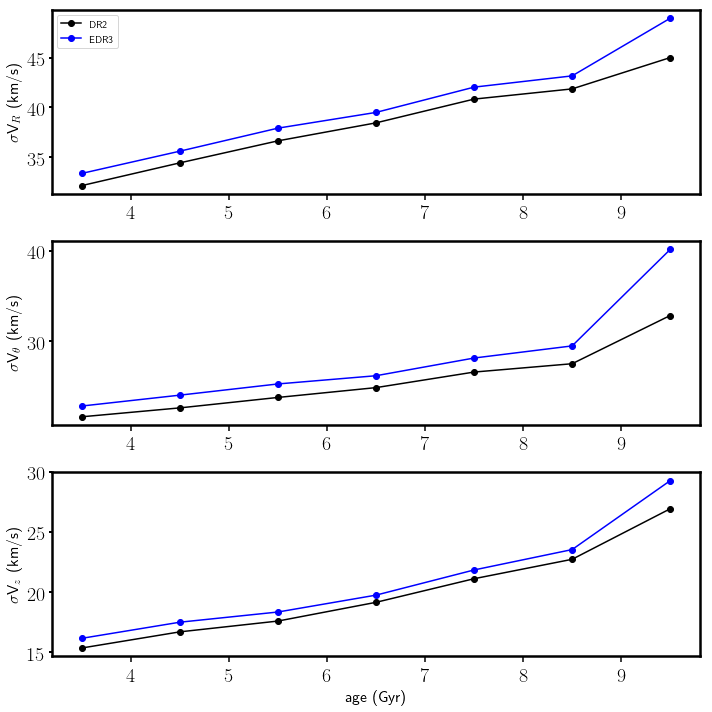

In [14]:
p.figure(figsize=(10,10))
ax1 = p.subplot(3,1,1)
p.plot(bincen,std_VR,'-o',label='DR2')
p.plot(bincen,std_VR_dr3,'-o',label='EDR3')
p.legend()
p.ylabel(r'$\sigma$V$_R$ (km/s)')

ax2 = p.subplot(3,1,2,sharex=ax1)
p.plot(bincen,std_Vt,'-o',label='DR2')
p.plot(bincen,std_Vt_dr3,'-o',label='EDR3')
p.ylabel(r'$\sigma$V$_{\theta}$ (km/s)')

ax1 = p.subplot(3,1,3,sharex=ax1)
p.plot(bincen,std_Vz,'-o')
p.plot(bincen,std_Vz_dr3,'-o',label='EDR3')
p.ylabel(r'$\sigma$V$_z$ (km/s)')
p.xlabel('age (Gyr)')
p.tight_layout()

*We now see that the age-velocity dispersion relations are roughly linear such that VELOCITY DISPERSION INCREASES with INCREASING age as expected. There are some differences between DR2 and EDR3 (why?)*